In [1]:
import keras
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import count
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import EarlyStopping
from scipy.stats import pearsonr
from tqdm import tqdm

Using TensorFlow backend.


In [0]:
BATCH_SIZE = 128
EPOCHS = 20
IMAGE_SIZE = 28
NUM_CLASSES = 10
MODEL_ADDITION_DELTA = 0.01
MODEL_ADDITION_PATIENCE = 3
MODEL_NAME = "FashionMNIST_augment"
PATH = ""

In [0]:
rotation_range = 10
width_shift_range = 0.1
height_shift_range = 0.1
brightness_range = (0.5,1.0)
zoom_range = 0.2
horizontal_flip = True

# Set seeds

In [0]:
np.random.seed(1)
tf.random.set_seed(1)

# Preprocess

In [0]:
def preprocess(imgs):
    
    return imgs.reshape(imgs.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

4423680/4422102 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [0]:
# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle= True)

#Data generators


In [0]:
datagen_rotation = ImageDataGenerator(rotation_range=rotation_range)
datagen_width_shift = ImageDataGenerator(width_shift_range=width_shift_range)
datagen_height_shift = ImageDataGenerator(height_shift_range=height_shift_range)
datagen_brightness = ImageDataGenerator(brightness_range=brightness_range)
datagen_zoom = ImageDataGenerator(zoom_range=zoom_range)
datagen_hflip = ImageDataGenerator(horizontal_flip=horizontal_flip)

In [0]:
datagens = []
datagens.append(datagen_rotation)
datagens.append(datagen_width_shift)
datagens.append(datagen_height_shift)
datagens.append(datagen_brightness)
datagens.append(datagen_zoom)
datagens.append(datagen_hflip)

# Model

In [0]:
def FashionMNISTmodel(imsize, num_classes, num_channels):
    inputs = Input((imsize,imsize,num_channels))
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', strides = 2)(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size = (2,2), strides=(2,2), padding = "same")(x)
    x = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='valid')(x)
    x = Conv2D(filters = 10, kernel_size = (1,1),strides = (1,1), padding = 'valid')(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate = 1e-04)

    model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
    return model

# Predict

In [0]:
def predict(models, X, Y):
    predictions = []

    for m in tqdm(models):
        predictions.append(np.argmax(m.predict(X), axis=1))

    prediction = np.transpose(predictions)
    prediction = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=prediction)

    return accuracy_score(prediction, np.argmax(Y, axis=1))

# Train

In [24]:
models = []
accuracies = [0]
patience = 0

for i in range(len(datagens)):

    print(f"Train model {i}")

    datagen = datagens[i].flow(x_train,y_train, batch_size = BATCH_SIZE) 
    model = FashionMNISTmodel(IMAGE_SIZE, NUM_CLASSES, 1)

    es = EarlyStopping(min_delta=0.01, patience=3)
    model.fit_generator(datagen,
                        epochs = EPOCHS,
                        validation_data = (x_test,y_test),
                        shuffle = True,
                        callbacks=[es])
    
    model.save_weights(PATH + MODEL_NAME + f"_weights-{i}.h5" )
    models.append(model)

    acc = predict(models, x_val, y_val)
    accuracies.append(acc)

    print(f"Model: {i} added. Resulting score: {acc}")

Train model 0
Epoch 1/20
375/375 [==============================] - 9s 23ms/step - loss: 2.1725 - accuracy: 0.2280 - val_loss: 2.1672 - val_accuracy: 0.2773
Epoch 2/20
375/375 [==============================] - 8s 22ms/step - loss: 1.8664 - accuracy: 0.4019 - val_loss: 1.7024 - val_accuracy: 0.4454
Epoch 3/20
375/375 [==============================] - 8s 22ms/step - loss: 1.6147 - accuracy: 0.4619 - val_loss: 1.4792 - val_accuracy: 0.4866
Epoch 4/20
375/375 [==============================] - 8s 22ms/step - loss: 1.4506 - accuracy: 0.5224 - val_loss: 1.3709 - val_accuracy: 0.5199
Epoch 5/20
375/375 [==============================] - 8s 22ms/step - loss: 1.3427 - accuracy: 0.5570 - val_loss: 1.2797 - val_accuracy: 0.5541
Epoch 6/20
375/375 [==============================] - 8s 22ms/step - loss: 1.2662 - accuracy: 0.5824 - val_loss: 1.2285 - val_accuracy: 0.5622
Epoch 7/20
375/375 [==============================] - 8s 22ms/step - loss: 1.2064 - accuracy: 0.5978 - val_loss: 1.1789 - val_ac

100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Model: 0 added. Resulting score: 0.6858333333333333
Train model 1
Epoch 1/20
375/375 [==============================] - 9s 24ms/step - loss: 2.2232 - accuracy: 0.2186 - val_loss: 2.1981 - val_accuracy: 0.3080
Epoch 2/20
375/375 [==============================] - 9s 24ms/step - loss: 1.9752 - accuracy: 0.3506 - val_loss: 1.8821 - val_accuracy: 0.3667
Epoch 3/20
375/375 [==============================] - 9s 24ms/step - loss: 1.7833 - accuracy: 0.3965 - val_loss: 1.6628 - val_accuracy: 0.4265
Epoch 4/20
375/375 [==============================] - 9s 24ms/step - loss: 1.6213 - accuracy: 0.4565 - val_loss: 1.5117 - val_accuracy: 0.4679
Epoch 5/20
375/375 [==============================] - 9s 23ms/step - loss: 1.4977 - accuracy: 0.5026 - val_loss: 1.4019 - val_accuracy: 0.5209
Epoch 6/20
375/375 [==============================] - 9s 24ms/step - loss: 1.4037 - accuracy: 0.5374 - val_loss: 1.3195 - val_accuracy: 0.5485
Epoch 7/20
375/375 [==============================] - 9s 24ms/step - loss: 1

100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


Model: 1 added. Resulting score: 0.6834166666666667
Train model 2
Epoch 1/20
375/375 [==============================] - 9s 24ms/step - loss: 2.3033 - accuracy: 0.1629 - val_loss: 2.2576 - val_accuracy: 0.1576
Epoch 2/20
375/375 [==============================] - 9s 23ms/step - loss: 2.0904 - accuracy: 0.3822 - val_loss: 1.9717 - val_accuracy: 0.4227
Epoch 3/20
375/375 [==============================] - 9s 23ms/step - loss: 1.8438 - accuracy: 0.4412 - val_loss: 1.6955 - val_accuracy: 0.4632
Epoch 4/20
375/375 [==============================] - 9s 24ms/step - loss: 1.6306 - accuracy: 0.4931 - val_loss: 1.5221 - val_accuracy: 0.5133
Epoch 5/20
375/375 [==============================] - 9s 24ms/step - loss: 1.4680 - accuracy: 0.5438 - val_loss: 1.3898 - val_accuracy: 0.5471
Epoch 6/20
375/375 [==============================] - 9s 24ms/step - loss: 1.3467 - accuracy: 0.5789 - val_loss: 1.2981 - val_accuracy: 0.5692
Epoch 7/20
375/375 [==============================] - 9s 24ms/step - loss: 1

100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


Model: 2 added. Resulting score: 0.6953333333333334
Train model 3
Epoch 1/20
375/375 [==============================] - 8s 22ms/step - loss: 2.2347 - accuracy: 0.2013 - val_loss: 2.6305 - val_accuracy: 0.1000
Epoch 2/20
375/375 [==============================] - 8s 20ms/step - loss: 1.9103 - accuracy: 0.3360 - val_loss: 2.7435 - val_accuracy: 0.1000
Epoch 3/20
375/375 [==============================] - 8s 20ms/step - loss: 1.6946 - accuracy: 0.4431 - val_loss: 2.8615 - val_accuracy: 0.1000
Epoch 4/20
375/375 [==============================] - 8s 20ms/step - loss: 1.5342 - accuracy: 0.5249 - val_loss: 3.0109 - val_accuracy: 0.1000


100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


Model: 3 added. Resulting score: 0.69425
Train model 4
Epoch 1/20
375/375 [==============================] - 8s 22ms/step - loss: 2.2723 - accuracy: 0.1533 - val_loss: 2.2140 - val_accuracy: 0.1712
Epoch 2/20
375/375 [==============================] - 8s 21ms/step - loss: 2.0174 - accuracy: 0.2993 - val_loss: 1.8858 - val_accuracy: 0.3728
Epoch 3/20
375/375 [==============================] - 8s 21ms/step - loss: 1.8116 - accuracy: 0.3925 - val_loss: 1.6630 - val_accuracy: 0.4144
Epoch 4/20
375/375 [==============================] - 8s 21ms/step - loss: 1.6473 - accuracy: 0.4436 - val_loss: 1.5072 - val_accuracy: 0.4811
Epoch 5/20
375/375 [==============================] - 8s 21ms/step - loss: 1.5242 - accuracy: 0.4881 - val_loss: 1.4044 - val_accuracy: 0.5047
Epoch 6/20
375/375 [==============================] - 8s 22ms/step - loss: 1.4340 - accuracy: 0.5154 - val_loss: 1.3235 - val_accuracy: 0.5395
Epoch 7/20
375/375 [==============================] - 8s 22ms/step - loss: 1.3596 - acc

100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Model: 4 added. Resulting score: 0.69275
Train model 5
Epoch 1/20
375/375 [==============================] - 3s 7ms/step - loss: 2.2812 - accuracy: 0.1039 - val_loss: 2.2562 - val_accuracy: 0.2183
Epoch 2/20
375/375 [==============================] - 2s 6ms/step - loss: 2.0710 - accuracy: 0.2689 - val_loss: 1.9509 - val_accuracy: 0.3566
Epoch 3/20
375/375 [==============================] - 2s 6ms/step - loss: 1.8258 - accuracy: 0.3755 - val_loss: 1.6973 - val_accuracy: 0.4028
Epoch 4/20
375/375 [==============================] - 2s 6ms/step - loss: 1.6324 - accuracy: 0.4370 - val_loss: 1.5369 - val_accuracy: 0.4693
Epoch 5/20
375/375 [==============================] - 2s 6ms/step - loss: 1.4980 - accuracy: 0.4907 - val_loss: 1.4232 - val_accuracy: 0.5077
Epoch 6/20
375/375 [==============================] - 2s 6ms/step - loss: 1.4019 - accuracy: 0.5243 - val_loss: 1.3402 - val_accuracy: 0.5496
Epoch 7/20
375/375 [==============================] - 2s 6ms/step - loss: 1.3311 - accuracy: 

100%|██████████| 6/6 [00:02<00:00,  2.35it/s]

Model: 5 added. Resulting score: 0.69575


# Results

# Accuracy vs nr of models
Visualizing the accuracy vs the number of models in the ensemble

In [30]:
accuracy_df = pd.DataFrame(accuracies, columns=["Accuracy"])
accuracy_df.insert(1, "Nr of models", accuracy_df.index)

display(accuracy_df)

accuracy_df.to_csv(PATH + MODEL_NAME + "_accuracy.csv")

,Accuracy,Nr of models
0,0.000000,0
1,0.685833,1
2,0.683417,2
3,0.695333,3
4,0.694250,4
5,0.692750,5
6,0.695750,6


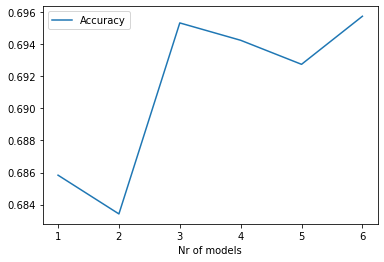

In [31]:
import matplotlib.pyplot as plt

# remove first row
accuracy_df = accuracy_df.iloc[1:]

accuracy_df.plot(x="Nr of models", y="Accuracy", xticks=accuracy_df["Nr of models"])
plt.show()

## Accuracy
The final accuracy of the ensamble on the test set

In [32]:
print("Accuracy: " + str(predict(models, x_test, y_test)))

100%|██████████| 6/6 [00:02<00:00,  2.70it/s]

Accuracy: 0.6909


## Correlation between models

In [33]:
predictions = []

for m in tqdm(models):
    predictions.append(np.argmax(m.predict(x_test), axis=1))

100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


In [34]:
correlation_matrix = []

for ix, x in enumerate(predictions):
  row = []
  
  for iy, y in enumerate(predictions):
    if (ix == iy):
      row.append(np.nan)
    else:
      row.append(pearsonr(x,y)[0])

  correlation_matrix.append(row)

correlation_matrix = np.array(correlation_matrix)
display(pd.DataFrame(correlation_matrix))
print("Average correlation: " + str(np.nanmean(correlation_matrix.flatten())))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,0,1,2,3,4,5
0,NaN,0.852910,0.845442,NaN,0.809065,0.844308
1,0.852910,NaN,0.802876,NaN,0.777948,0.843794
2,0.845442,0.802876,NaN,NaN,0.797493,0.820954
3,NaN,NaN,NaN,NaN,NaN,NaN
4,0.809065,0.777948,0.797493,NaN,NaN,0.778127
5,0.844308,0.843794,0.820954,NaN,0.778127,NaN


Average correlation: 0.817291801398415
